In [438]:
from skimage.io import imread
import numpy as np
from scipy.fftpack import dct, idct
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
import time


In [439]:
rootfolder = '.'

Definition of dct2 and idct2 (they are not builtin functions)

In [440]:
def dct2(s):
    return dct(dct(s.T, norm='ortho').T, norm='ortho')

def idct2(x):
    return idct(idct(x.T, norm='ortho').T, norm='ortho')

Useful function for plot the 2D DCT dictionary

In [441]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Load the image and rescale it in $[0,1]$

In [442]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255
imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [443]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

In [444]:
def peak_signal_noise_ratio(A,B):
  return 10 * np.log10(1/(np.square(np.subtract(A, B)).mean()))

Compute the psnr of the noisy input

In [445]:
psnr_noisy = peak_signal_noise_ratio(img, noisy_img)
psnr_noisy

22.146630831213862

Text(0.5, 1.0, 'Noisy image, PSNR = 22.15')

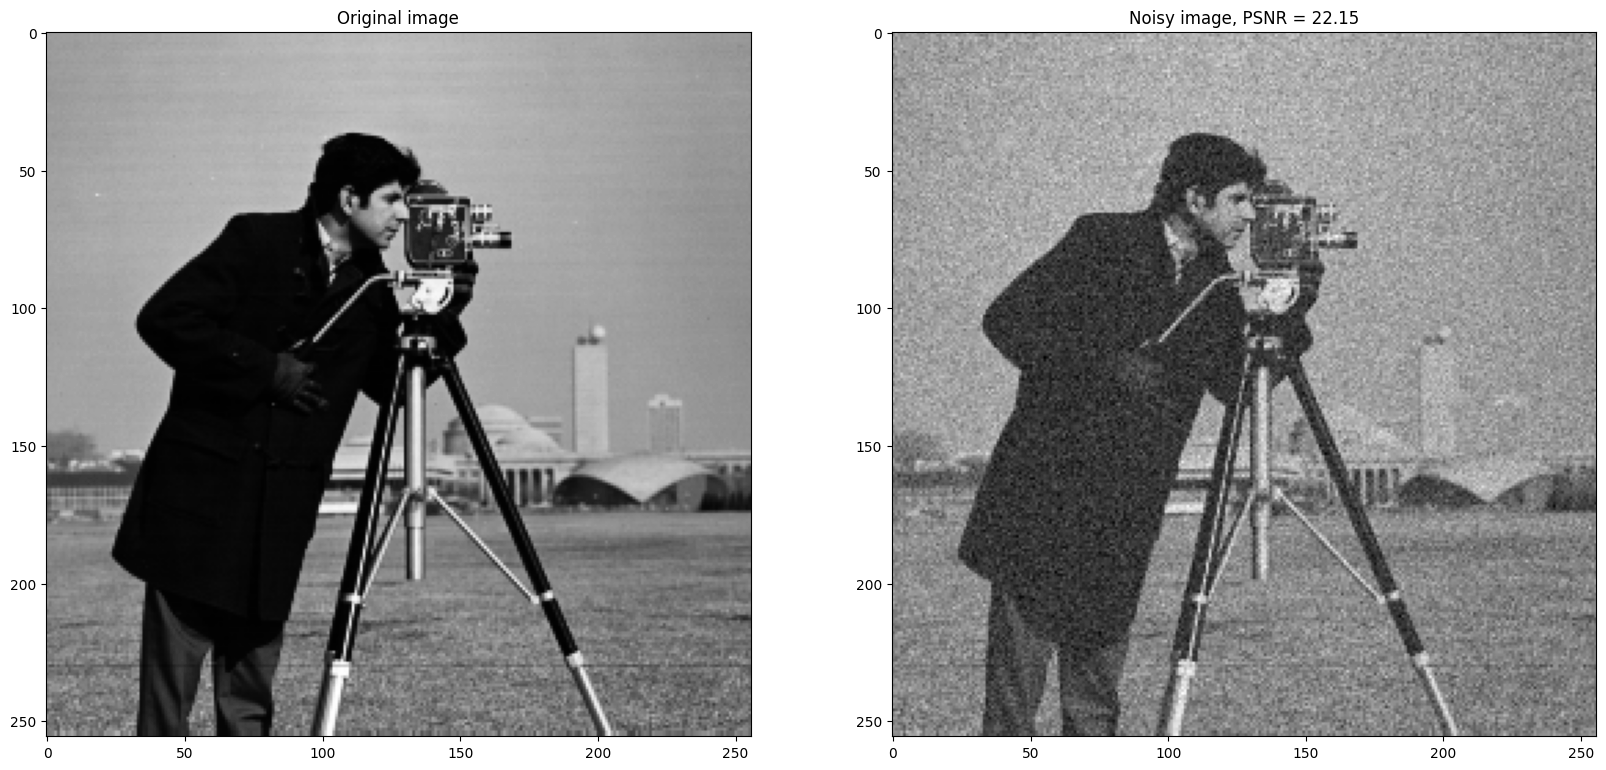

In [446]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


DCT denoising
-------------
Generate the DCT basis

In [447]:
D = np.zeros((M, M))
cnt = 0
for i in range(p):
    for j in range(p):
        # Initialize a patch with zeros
        Z = np.zeros((p, p))
        # Set one element to 1 to create a basis matrix
        Z[i, j] = 1
        # Apply the inverse DCT (idct2) to generate the basis image
        basis_image = idct2(Z).flatten()
        D[:, cnt] = basis_image
        cnt = cnt + 1


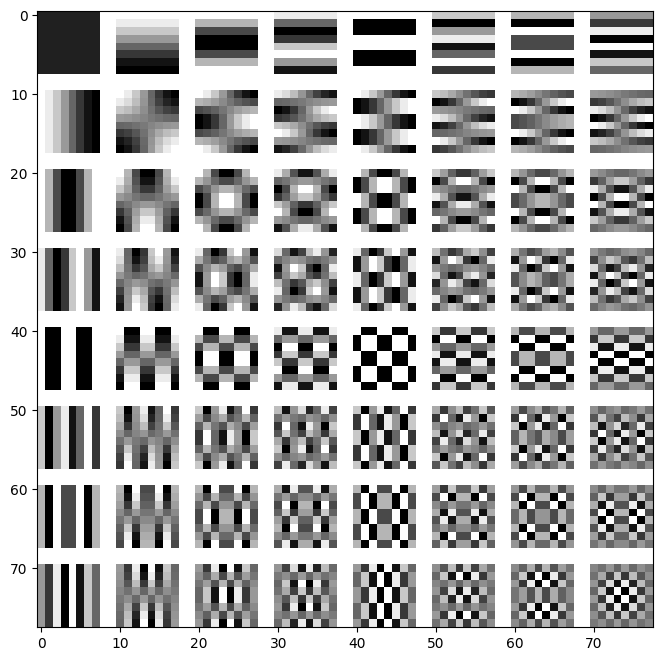

In [448]:
D_img = get_dictionary_img(D)
plt.figure(figsize=(8, 8))
plt.imshow(D_img, cmap='gray')

Denoising: set parameters and initialize the variables

In [449]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# set the threshold for the Hard Thresholding
tau = np.sqrt(np.log(p**2)) * sigma_noise # Donoho says: sigma * sqrt(2*log(p^2))

# define the step
STEP = 1

Perform the denoising pathwise

In [450]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i: i + p, j: j + p]

        # compute the representation w.r.t. the 2D DCT dictionary
        x = dct2(s)

        # perform the hard thresholding (do not perform HT on the DC!)
        x_HT = x * (np.abs(x) > tau)

        # perform the reconstruction
        s_hat = idct2(x_HT)

        nnz = np.count_nonzero(x_HT)  # Number of non-zero coefficients
        if nnz > 0:
            w = 1.0 / nnz
        else:
            w = 1.0

        # put the compressed patch into the compressed image using the computed weight
        # update img_hat
        img_hat[i:i+p, j:j+p] += s_hat.reshape(p,p) * w

        # store the weight of the current patch in the weight matrix
        # update weights
        weights[i:i+p, j:j+p] += w

Normalize the estimated image with the computed weights

In [451]:
img_hat /= weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 28.96')

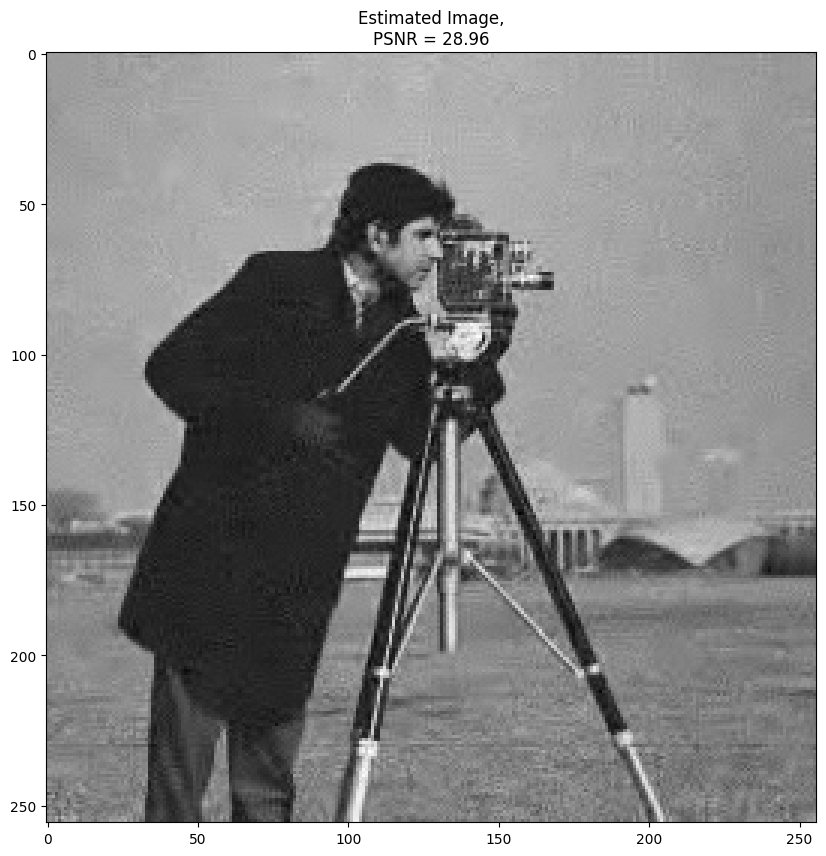

In [452]:
psnr = peak_signal_noise_ratio(img_hat,img)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr:.2f}')


/var/folders/8g/fgfxv9zs0mqf54m85lvfshww0000gn/T/ipykernel_4012/2583784032.py:44: RuntimeWarning: invalid value encountered in divide
  img_hat = np.where(weights !=0, img_hat/weights, img_hat)


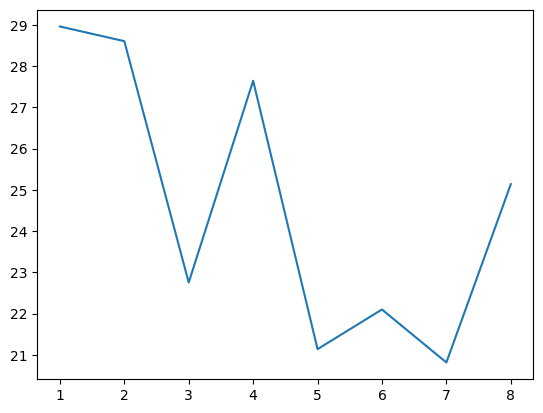

In [453]:
# Quick check to see the PSNR against STEP

steps = np.arange(1,p+1)
psnrs = []

for STEP_test in steps:
  # initialize the estimated image
  img_hat = np.zeros_like(img)

  # initialize the weight matrix
  weights = np.zeros_like(img)

  # set the threshold for the Hard Thresholding
  tau = np.sqrt(np.log(p**2)) * sigma_noise # Donoho says: sigma * sqrt(2*log(p^2))
  
  for i in range(0, imsz[0] - p + 1, STEP_test):
    for j in range(0, imsz[1] - p + 1, STEP_test):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i: i + p, j: j + p]

        # compute the representation w.r.t. the 2D DCT dictionary
        x = dct2(s)

        # perform the hard thresholding (do not perform HT on the DC!)
        x_HT = x * (np.abs(x) > tau)

        # perform the reconstruction
        s_hat = idct2(x_HT)

        nnz = np.count_nonzero(x_HT)  # Number of non-zero coefficients
        if nnz > 0:
            w = 1.0 / nnz
        else:
            w = 1.0

        # put the compressed patch into the compressed image using the computed weight
        # update img_hat
        img_hat[i:i+p, j:j+p] += s_hat.reshape(p,p) * w

        # store the weight of the current patch in the weight matrix
        # update weights
        weights[i:i+p, j:j+p] += w
        
  img_hat = np.where(weights !=0, img_hat/weights, img_hat)
  psnrs.append(peak_signal_noise_ratio(img_hat,img))
  
plt.plot(steps, psnrs)

Wiener Filtering
----------------
Initialize the estimated image via Wiener Filtering

In [454]:
img_hat_wiener = np.zeros_like(img)
weights = np.zeros_like(img)

Perform the denoising patchwise

In [455]:
'''# Compute the horizontal derivative of the noisy image
differences = noisy_img[:, 1:] - noisy_img[:, :-1]

# Compute sigma as the empirical std
sigma_hat_emp = np.std(differences)

# Use MAD to estimate the noise level sigma
sigma_hat = np.median(np.abs(differences - np.median(differences))) / (np.sqrt(2) * 0.67449)'''

'# Compute the horizontal derivative of the noisy image\ndifferences = noisy_img[:, 1:] - noisy_img[:, :-1]\n\n# Compute sigma as the empirical std\nsigma_hat_emp = np.std(differences)\n\n# Use MAD to estimate the noise level sigma\nsigma_hat = np.median(np.abs(differences - np.median(differences))) / (np.sqrt(2) * 0.67449)'

In [456]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # Extract the patch from the noisy image
        s = noisy_img[i: i + p, j: j + p]
        
        # Compute the representation w.r.t. the 2D DCT dictionary
        x = dct2(s)
        
        # Extract the patch from the image estimated by HT
        s_hat_HT = img_hat[i: i + p, j: j + p]  # Assuming img_hat is the HT estimate
        
        # Compute the Wiener filter coefficients, skipping the DC component
        u = dct2(s_hat_HT)
        x_wie = u**2 / (u**2 + sigma_noise**2) * x 
        
        # Perform the reconstruction
        s_hat_wie = idct2(x_wie)
        
        # Use uniform weights to aggregate the multiple estimates
        w = 1
        
        # Update img_hat_wiener and weights
        img_hat_wiener[i:i+p, j:j+p] += s_hat_wie.reshape(p, p) * w
        weights[i:i+p, j:j+p] += w

# Normalize the estimated image with the computed weights
img_hat_wiener /= weights


Compute the psnr of the two estimates

Text(0.5, 1.0, 'Wiener Estimate, PSNR = 28.23')

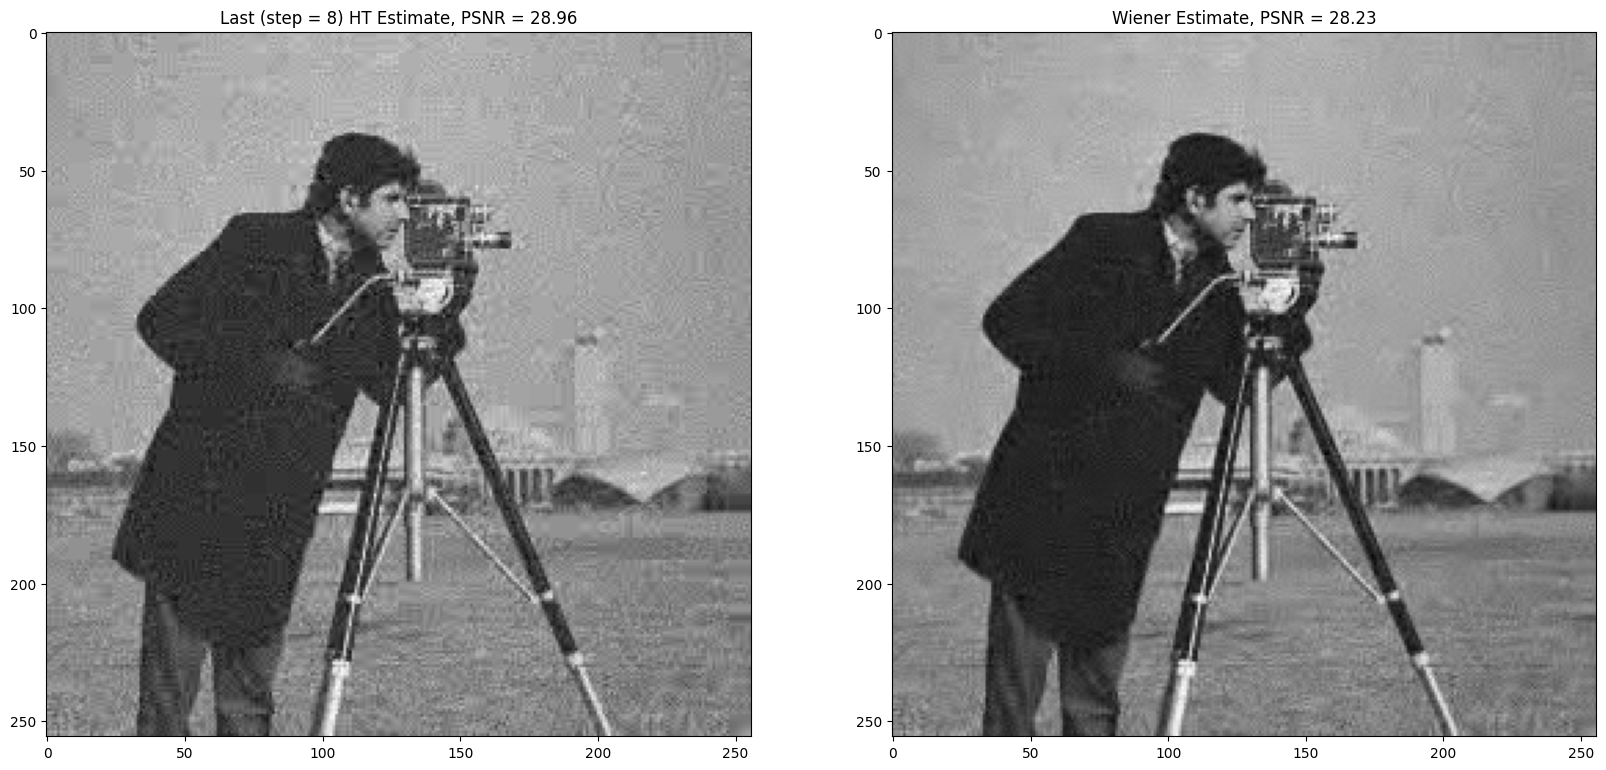

In [457]:
psnr_wiener = peak_signal_noise_ratio(img_hat_wiener,img)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img_hat, cmap='gray')
ax[0].set_title(f'Last (step = {STEP_test}) HT Estimate, PSNR = {psnr:.2f}')

ax[1].imshow(img_hat_wiener, cmap='gray')
ax[1].set_title(f'Wiener Estimate, PSNR = {psnr_wiener:.2f}')


Noise estimation
----------------
Compute the horizontal derivative of the image

In [462]:
differences = img_hat[:, 1:] - img_hat[:, :-1]


Compute sigma as the empirical std

In [463]:
sigma_hat_emp = np.std(differences)


Use MAD to estimate the noise level sigma

In [464]:
sigma_hat = np.median(np.abs(differences - np.median(differences))) / (np.sqrt(2) * 0.67449)


In [465]:
print(f'sigma: {sigma_noise:.3f}, sigma_hat (empirical std): {sigma_hat_emp:.3f}, sigma_hat (MAD): {sigma_hat:.3f}')


sigma: 0.078, sigma_hat (empirical std): 0.104, sigma_hat (MAD): 0.045
